# Load required libraries

In [5]:
import os
import numpy as np  
import pandas as pd
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib

import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# 1 Read and explore the given dataset

In [6]:
mydf = pd.read_csv("ratings_Electronics.csv",names=["userID", "ProductID", "Rating", "Timestamp"])
mydf.head(5)  

,userID,ProductID,Rating,Timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [7]:
mydf.shape

(7824482, 4)

In [8]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
userID       object
ProductID    object
Rating       float64
Timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


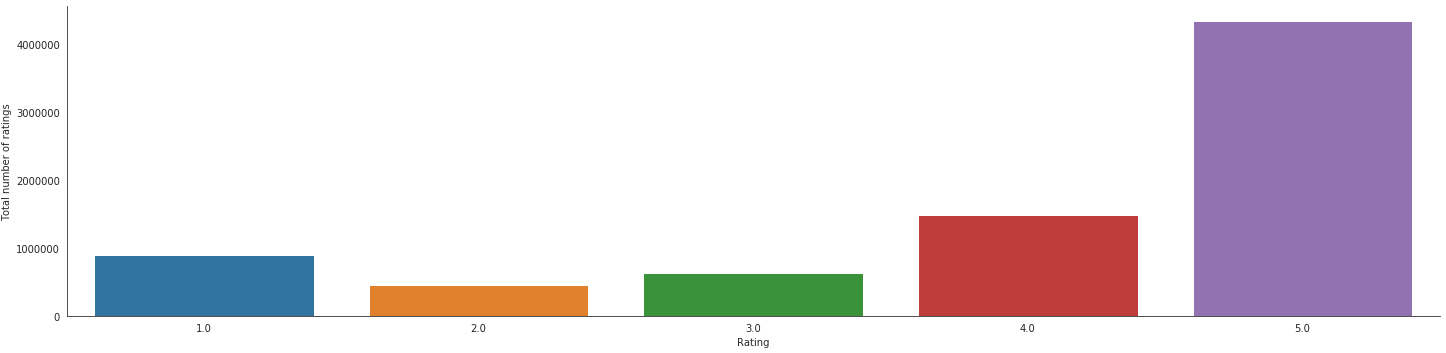

In [9]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=mydf, aspect=4.0,kind='count')
    g.set_ylabels("Total number of ratings")

# 2 Take a subset of data and make it less sparse

In [10]:
df_Subset = mydf[mydf.groupby('userID')['Rating'].transform('size') >=50]
mydf_Subset=df_Subset

In [11]:
print('Number of users who have rated 50 or more items =', len(mydf))
print('Number of unique USERS in final data = ', mydf['userID'].nunique())
print('Number of unique PRODUCTS in final data = ', mydf['ProductID'].nunique())

Number of users who have rated 50 or more items = 7824482
Number of unique USERS in final data =  4201696
Number of unique PRODUCTS in final data =  476002


In [12]:
Ratings_matrix = mydf_Subset.pivot(index = 'userID', columns ='ProductID', values = 'Rating').fillna(0)
print('Shape of final_ratings_matrix: ', Ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(Ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = Ratings_matrix.shape[0] * Ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


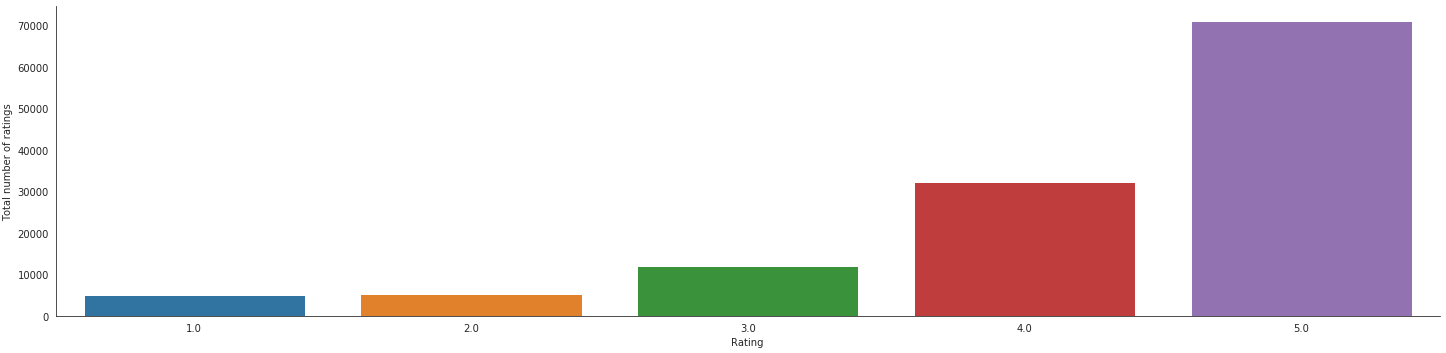

In [13]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=mydf_Subset, aspect=4.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [14]:
mydf_Subset.count()

userID       125871
ProductID    125871
Rating       125871
Timestamp    125871
dtype: int64

In [15]:
mydf_Subset.head(2)

,userID,ProductID,Rating,Timestamp
94,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
118,AT09WGFUM934H,0594481813,3.0,1377907200


# 3. Split the data into train and test

In [17]:
train_data, test_data = train_test_split(mydf_Subset,test_size=0.30,random_state=42)
train_data.head()

,userID,ProductID,Rating,Timestamp
3406191,A30R8VFR16RE32,B003KPBRRW,5.0,1284076800
2044529,A3MMR2WDKAK0PA,B001GNBD8I,2.0,1227139200
5706800,AGOH8N902URMW,B007BXD66E,5.0,1345593600
3741724,A2RTVGR9B1M600,B004071ZXA,5.0,1302220800
4756538,A1QQA7Y92L4F9R,B0057Q49F4,5.0,1330992000


In [20]:
train_data.shape

(88109, 4)

In [21]:
test_data.shape

(37762, 4)

# 4 Build popularity based Recommendation Model

In [22]:
#Count of user_id for each unique product as recommendation score 
data_grouped = mydf_Subset.groupby('ProductID').agg({'userID': 'count'}).reset_index()
data_grouped.rename(columns = {'userID': 'score'},inplace=True)
data_grouped.head(10)

,ProductID,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6
5,1400501520,1
6,1400501776,2
7,1400532620,2
8,1400532655,6
9,140053271X,2


In [23]:
#Sort the products on recommendation score 
data_sort = data_grouped.sort_values(['score', 'ProductID'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
data_sort['Rank'] = data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = data_sort.head(10) 
popularity_recommendations

,ProductID,score,Rank
39003,B0088CJT4U,206,1.0
24827,B003ES5ZUU,184,2.0
11078,B000N99BBC,167,3.0
38250,B007WTAJTO,164,4.0
38615,B00829TIEK,149,5.0
38611,B00829THK0,137,6.0
39338,B008DWCRQW,137,7.0
21982,B002R5AM7C,128,8.0
28761,B004CLYEDC,118,9.0
22210,B002SZEOLG,113,10.0


In [24]:
# Recommendataion using popularity based recommender model
def recommend(user_id, recoModel):     
    user_recommendations = recoModel 
          
    # User_id column 
    user_recommendations['userId'] = user_id 
      
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [18]:
find_recom = [2044529,5706800,4756538,3406191]
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i, popularity_recommendations))    
    print("\n")

Here is the recommendation for the userId: 2044529

       userId   ProductID  score  Rank
146   2044529  B00004SB92      7   1.0
321   2044529  B00004ZCJE      5   2.0
479   2044529  B00005LEN4      5   3.0
1073  2044529  B00007KDVI      5   4.0
1199  2044529  B00008OE6I      5   5.0
2428  2044529  B0009RKL5S      5   6.0
2542  2044529  B000BKJZ9Q      5   7.0
299   2044529  B00004Z5M1      4   8.0
418   2044529  B00005AW1H      4   9.0
677   2044529  B0000645C9      4  10.0


Here is the recommendation for the userId: 5706800

       userId   ProductID  score  Rank
146   5706800  B00004SB92      7   1.0
321   5706800  B00004ZCJE      5   2.0
479   5706800  B00005LEN4      5   3.0
1073  5706800  B00007KDVI      5   4.0
1199  5706800  B00008OE6I      5   5.0
2428  5706800  B0009RKL5S      5   6.0
2542  5706800  B000BKJZ9Q      5   7.0
299   5706800  B00004Z5M1      4   8.0
418   5706800  B00005AW1H      4   9.0
677   5706800  B0000645C9      4  10.0


Here is the recommendation for the

In [25]:
# User recommendation for each Unique product 
mydf_grouped = mydf_Subset.groupby('ProductID').agg({'userID': 'count'}).reset_index()
mydf_grouped.rename(columns = {'userID': 'score'},inplace=True)
mydf_grouped.head(10)

,ProductID,score
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6
5,1400501520,1
6,1400501776,2
7,1400532620,2
8,1400532655,6
9,140053271X,2


In [26]:
# Products sorted on recommendation score 
mydf_sort = mydf_grouped.sort_values(['score', 'ProductID'], ascending = [0,1]) 
      
# Raking based on score 
mydf_sort['Rank'] = mydf_sort['score'].rank(ascending=0, method='first') 
          
# Top recommended products
mydf_recommendations = mydf_sort.head(10) 
mydf_recommendations

,ProductID,score,Rank
39003,B0088CJT4U,206,1.0
24827,B003ES5ZUU,184,2.0
11078,B000N99BBC,167,3.0
38250,B007WTAJTO,164,4.0
38615,B00829TIEK,149,5.0
38611,B00829THK0,137,6.0
39338,B008DWCRQW,137,7.0
21982,B002R5AM7C,128,8.0
28761,B004CLYEDC,118,9.0
22210,B002SZEOLG,113,10.0


In [21]:
find_recom = [4756538,3741724,5706800]
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i, mydf_recommendations))    
    print("\n")

Here is the recommendation for the userId: 4756538

       userId   ProductID  score  Rank
146   4756538  B00004SB92      7   1.0
321   4756538  B00004ZCJE      5   2.0
479   4756538  B00005LEN4      5   3.0
1073  4756538  B00007KDVI      5   4.0
1199  4756538  B00008OE6I      5   5.0
2428  4756538  B0009RKL5S      5   6.0
2542  4756538  B000BKJZ9Q      5   7.0
299   4756538  B00004Z5M1      4   8.0
418   4756538  B00005AW1H      4   9.0
677   4756538  B0000645C9      4  10.0


Here is the recommendation for the userId: 3741724

       userId   ProductID  score  Rank
146   3741724  B00004SB92      7   1.0
321   3741724  B00004ZCJE      5   2.0
479   3741724  B00005LEN4      5   3.0
1073  3741724  B00007KDVI      5   4.0
1199  3741724  B00008OE6I      5   5.0
2428  3741724  B0009RKL5S      5   6.0
2542  3741724  B000BKJZ9Q      5   7.0
299   3741724  B00004Z5M1      4   8.0
418   3741724  B00005AW1H      4   9.0
677   3741724  B0000645C9      4  10.0


Here is the recommendation for the

# This is not personalized recommendation rather it is Popularity based recommendataion.
# Since this ispopularity-based recommender model, Model or Train/Test accuracy is not required 

# 5 Build Collaborative Filtering model

In [27]:
train_data.shape

(88109, 4)

In [28]:
test_data.shape

(37762, 4)

In [29]:
mydf_CF = pd.concat([train_data, test_data]).reset_index()
mydf_CF.head()

,index,userID,ProductID,Rating,Timestamp
0,3406191,A30R8VFR16RE32,B003KPBRRW,5.0,1284076800
1,2044529,A3MMR2WDKAK0PA,B001GNBD8I,2.0,1227139200
2,5706800,AGOH8N902URMW,B007BXD66E,5.0,1345593600
3,3741724,A2RTVGR9B1M600,B004071ZXA,5.0,1302220800
4,4756538,A1QQA7Y92L4F9R,B0057Q49F4,5.0,1330992000


In [30]:
# Collaborative Filtering based on users

mydf_pivot = mydf_CF.pivot(index = 'userID', columns ='ProductID', values = 'Rating').fillna(0)
mydf_pivot.shape
mydf_pivot.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
mydf_pivot['user_index'] = np.arange(0, mydf_pivot.shape[0], 1)
mydf_pivot.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,user_index
userID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [32]:
mydf_pivot.set_index(['user_index'], inplace=True)

# Actual ratings given by users
mydf_pivot.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# SVD Method

In [34]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition

U, sigma, Vt = svds(mydf_pivot, k = 10)

sigma = np.diag(sigma)

In [35]:
user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
mydf_predict = pd.DataFrame(user_predicted_ratings, columns = mydf_pivot.columns)
mydf_predict.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [36]:
# Highest predicted ratings will be recommended

def recommend_items(userID, mydf_pivot, mydf_predict, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    
    sorted_user_ratings = mydf_pivot.iloc[user_idx].sort_values(ascending=False)
    
    sorted_user_predictions = mydf_predict.iloc[user_idx].sort_values(ascending=False)
    
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [37]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 2
num_recommendations = 10
recommend_items(userID, mydf_pivot, mydf_predict, num_recommendations)


Below are the recommended items for user(user_id = 2):

                   user_ratings  user_predictions
Recommended Items                                
B000N99BBC                  0.0          1.464528
B00829TIEK                  0.0          1.271871
B004CLYEDC                  0.0          1.251298
B00829THK0                  0.0          1.097851
B0034CL2ZI                  0.0          0.803442
B00834SJSK                  0.0          0.801665
B00829TIA4                  0.0          0.798920
B004CLYEFK                  0.0          0.751124
B00834SJNA                  0.0          0.746606
B004T9RR6I                  0.0          0.721282


# 6.Evaluate both the models

In [38]:
# Actual ratings given by the users
Ratings_matrix.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
userID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# Average ACTUAL rating for each item
Ratings_matrix.mean().head()

ProductID
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
dtype: float64

In [40]:
# Predicted ratings 
mydf_predict.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [41]:
# Average PREDICTED rating for each item
mydf_predict.mean().head()

ProductID
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [42]:
mydf_rmse = pd.concat([Ratings_matrix.mean(), mydf_predict.mean()], axis=1)
mydf_rmse.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(mydf_rmse.shape)
mydf_rmse['item_index'] = np.arange(0, mydf_rmse.shape[0], 1)
mydf_rmse.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
ProductID,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [44]:
RMSE = round((((mydf_rmse.Avg_actual_ratings - mydf_rmse.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



# We have been able to achieve some good accuracy

In [45]:
from surprise import SVD
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import accuracy

ModuleNotFoundError: No module named 'surprise'

In [39]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
mydata = Dataset.load_from_df(mydf_Subset[['userID', 'ProductID', 'Rating']], reader)

In [40]:
 #define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(mydata):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=False)

In [41]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(mydata)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0597802966027983
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


# 7. Get top - K ( K = 5) recommendations

In [42]:
userID = 20
num_recommendations = 5
recommend_items(userID, mydf_pivot, mydf_predict, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B000050AQ7                  0.0          0.200175
B00005LB8P                  0.0          0.176587
B0000632FZ                  0.0          0.170667
B00006JI6U                  0.0          0.168738
B0000898TE                  0.0          0.164765


# 8. Summary - 

# The Popularity-based recommender system is based on the actual recommendations and is not personalised to any user. Meaning all the users will get the same popularity output.

# Personalized recommendation will be from Model-based Collaborative Filtering. This takes into account the actual user product interaction and the historical data of the  user.